In [1]:
import warnings
warnings.filterwarnings('ignore')
from pc_model import GLM_Fitter, Marr2Algorithms, make_LM
from csv_analysis import make_regression_plots
import numpy as np
import seaborn as sb
import sys
from scipy.stats import wilcoxon, ttest_1samp, mannwhitneyu, pearsonr, entropy, norm
from scipy.ndimage import gaussian_filter
from scipy.special import kl_div
#sb.set()
import matplotlib

sb.set()
husl = sb.color_palette("husl",8)
cp = sb.color_palette()
#sb.palplot(husl)
#sb.set_style('ticks')
#sb.set_style('whitegrid')
sb.reset_orig()
#sb.set_style('whitegrid')
sb.set_style('white')
sb.axes_style({'ytick.right':False})
#sb.set_style("ticks", {"xtick.major.size": -1, "ytick.major.size": -1})
#sb.set_style({'xtick.minor.size': 0})
sb.set_style({"xtick.direction": "in","ytick.direction": "in", 'ytick.right':False, 'ytick.left': False})
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as pl
from collections import Counter
from iventure.utils_bql import query
np.random.seed()
%matplotlib inline


In [3]:
p_inits = np.load('p_inits.npy').tolist()
strike_params = np.load('strike_params.npy')
marralgs = Marr2Algorithms(p_inits, strike_params, 0)
glm_fitter = GLM_Fitter()
glm_fitter.glm_fits()
marralgs.glm_models = glm_fitter.glm_models
marralgs.extract_static_params()
print marralgs.fails

[]


in bayes
One Sample T on Medians
Ttest_1sampResult(statistic=-20.563924722678784, pvalue=3.9548074727131421e-51)
[0.061724777075188253, 0.075523190200123755, 0.15499582955069974]


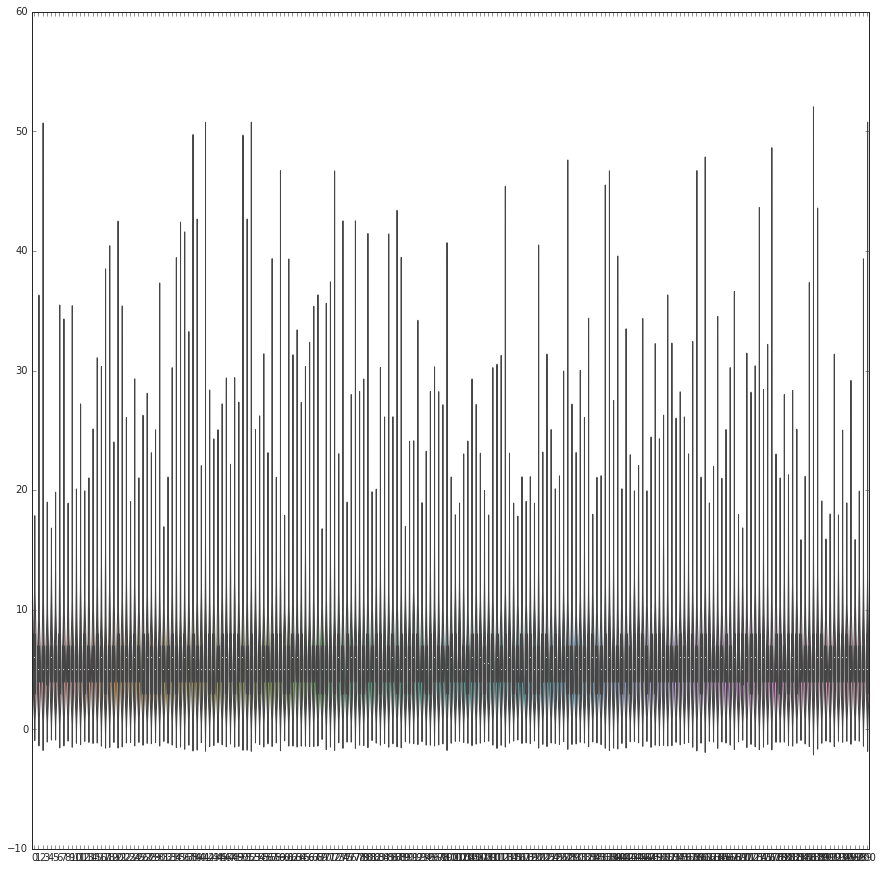

ValueError: cannot set an array element with a sequence

In [4]:
marralgs.strike_ci = .05
marralgs.marr_bdb_file.np_prng.seed()
marralgs.run_marr2_models(200)
marralgs.result_compiler()
sd = marralgs.marr_bdb_file.np_prng.get_state()
np.save('random_state.npy', sd)

In [7]:
# RANDOM STATE IS A TUPLE OF THE FORM ('MT19937', NP.ARRAY DESCRIBING STATE)
np.save('random_state.npy', sd[1])

0.00512730565739
0.188447991392
{'alt_m_pos': 0.33235833646273094, 'az_m': 0.40798443804487106, 'dist_m': 0.8260589748682331, 'dist_b': 1.912993265824332, 'alt_b_neg': 0.17064043705564944, 'az_b': 0.0058167189351404219, 'alt_b_pos': 0.21829394999526702, 'alt_m_neg': 1.0047671903656354}
[8, 9, 3, 3, 6]
225
181
WilcoxonResult(statistic=261.0, pvalue=1.1329876863340637e-16)
6.0
4.0
5.0


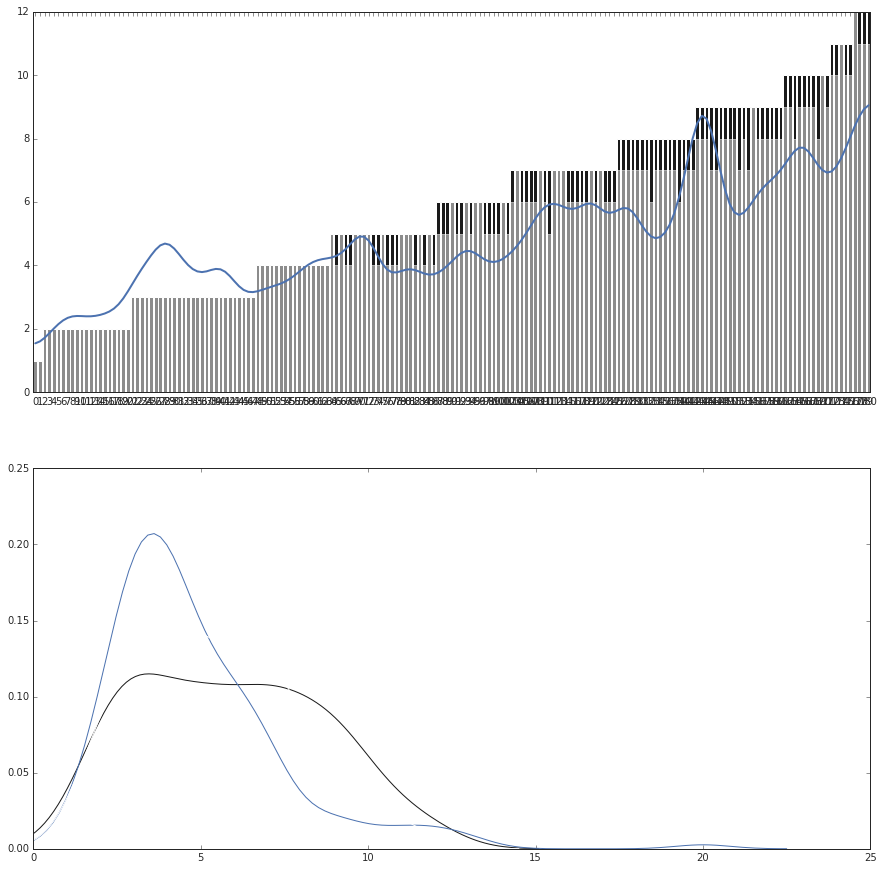

In [26]:
#marralgs.bouts_static = marralgs.bouts_static_prevalidation
marralgs.validate_bayes_model([mod_az0to5, mod_altpos, mod_altneg, mod_dist], 1, 1)
print mod_az0to5.params[0]
print mod_az0to5.params[1]
print marralgs.static_params
print marralgs.bouts_static[0:5]


bouts_realfish_model = np.load('real_model_results.npy')
print len(bouts_realfish_model)
static_bouts_for_barplot = [[d] for d in marralgs.bouts_static]
bayes_bouts_for_barplot = []


for i in range(len(marralgs.bouts_static)):
    trial_bouts = []
    for bb in marralgs.bouts_bayes:
        trial_bouts.append(bb[i])
    bayes_bouts_for_barplot.append(trial_bouts)
    
non_nan_real_args = np.where(np.isfinite(bouts_realfish_model))



bouts_realfish_model = bouts_realfish_model[non_nan_real_args]

print len(bouts_realfish_model)

static_bouts_for_barplot = np.array(static_bouts_for_barplot)[non_nan_real_args]
bayes_bouts_for_barplot = np.array(bayes_bouts_for_barplot)[non_nan_real_args]

static_bouts = np.array([b[0] for b in static_bouts_for_barplot])
    
real_bouts_for_barplot = np.array([[b] for b in bouts_realfish_model])   
sorted_by_numbouts = np.argsort(static_bouts)
#sorted_by_numbouts = np.argsort(bouts_realfish_model)
#sorted_by_numbouts = np.argsort(np.array([np.nanmedian(b) for b in bayes_bouts_for_barplot]))

# Too much going on if you add error bars. CI=None, but show full distribution
# of bayes in the KDE. 
fig, ax = pl.subplots(2,1, figsize=(15,15))
#sb.barplot(data=real_bouts_for_barplot[sorted_by_numbouts].tolist(), color=cp[3], estimator=np.nanmedian, ci=95, errwidth=.1, ax=ax[0])
sb.barplot(data=static_bouts_for_barplot[sorted_by_numbouts].tolist(), color='k', estimator=np.nanmedian, ci=None, alpha=1, ax=ax[0])
sb.barplot(data=bayes_bouts_for_barplot[sorted_by_numbouts].tolist(), color='w', estimator=(lambda x: np.ceil(np.median(x))), ci=None, alpha=.5, ax=ax[0])
fig.savefig('bp.pdf')

# sb.pointplot(data=real_bouts_for_barplot[sorted_by_numbouts].tolist(), marker=None, ci=None, color=cp[3], ax=ax[0])
# sb.pointplot(data=static_bouts_for_barplot[sorted_by_numbouts].tolist(), marker=None, ci=None, color=cp[4], ax=ax[0])
# sb.pointplot(data=bayes_bouts_for_barplot[sorted_by_numbouts].tolist(), marker=None, ci=None, color=cp[9], ax=ax[0])

ax[0].plot(gaussian_filter(real_bouts_for_barplot[sorted_by_numbouts], 3).tolist(), marker=None, color=cp[0], linewidth=2)
#ax[0].plot(static_bouts_for_barplot[sorted_by_numbouts].tolist(), marker=None, color=cp[0], linewidth=.5)
#ax[0].plot([np.nanmedian(b) for b in bayes_bouts_for_barplot[sorted_by_numbouts]], marker=None, color=cp[2], linewidth=.5)

sb.kdeplot(static_bouts, ax=ax[1], color='k')
sb.kdeplot(bouts_realfish_model, ax=ax[1], color=cp[0])
sb.kdeplot([np.ceil(np.median(b)) for b in bayes_bouts_for_barplot], ax=ax[1], color='w')
#sb.kdeplot(np.concatenate(bayes_bouts_for_barplot), ax=ax[1])
ax[1].set_xlim([0, 25])


print wilcoxon(static_bouts, [np.ceil(np.median(b)) for b in bayes_bouts_for_barplot])

fig.savefig('marr_comparison.pdf')
print np.nanmedian(static_bouts)
print np.nanmedian(bouts_realfish_model)
print np.nanmedian(np.concatenate(bayes_bouts_for_barplot))

(array([  2,  23,  35,  90, 104, 132]),)
3.0


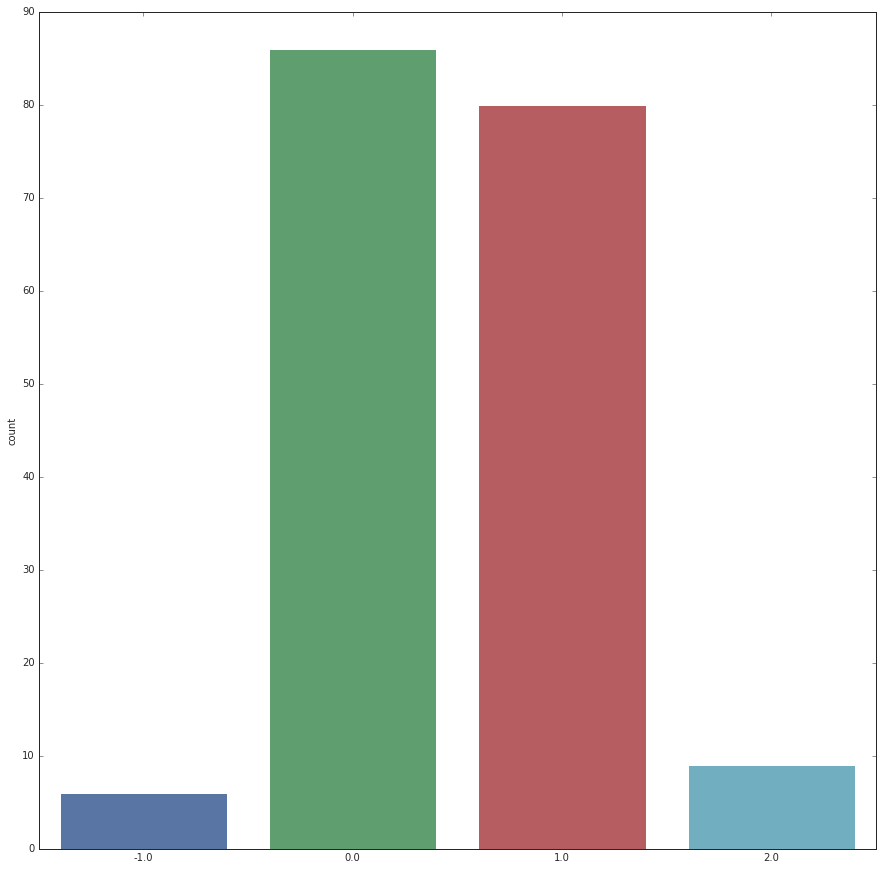

In [27]:
static_vs_bayes = np.array(static_bouts - np.ceil(np.median(bayes_bouts_for_barplot, axis=1)))
real_vs_bayes = np.array(bouts_realfish_model - np.ceil(np.median(bayes_bouts_for_barplot, axis=1)))
real_vs_static = np.array(bouts_realfish_model - static_bouts)

# nans in static never caught para. prob b/c starts too close and has no way of getting around that. 
# may be a bad choice to do this. don't want nans in the static model for it being too close, but
# noise in bayes helps this too. 

static_vs_bayes = np.array([i if np.isfinite(i) else 1 for i in static_vs_bayes])

hunts_where_static_wins = np.where(static_vs_bayes < 0)
print hunts_where_static_wins
print np.nanmedian(np.array(static_bouts)[hunts_where_static_wins])

net_wins_for_bayes_vs_static = np.sum(np.sign(static_vs_bayes))
net_wins_for_bayes_vs_real = np.sum(np.sign(real_vs_bayes))                         
net_wins_for_static_vs_real = np.sum(np.sign(real_vs_static))    
                         
fig, ax = pl.subplots(1,1, figsize=(15,15))
#sb.violinplot(data=[static_vs_bayes, real_vs_bayes, real_vs_static], bw=.3, orient='v', whis=[5,95], showfliers=False, ax=ax)
#sb.boxplot(data=[static_vs_bayes, real_vs_bayes, real_vs_static], orient='v', whis=[5,95], showfliers=False, ax=ax)
#sb.violinplot(data=[static_vs_bayes], bw=.3, orient='v', ax=ax, color=cp[7])
sb.countplot(static_vs_bayes, ax=ax)
#sb.kdeplot(static_vs_bayes, ax=ax)
#ax.set_ylim([0, 1])
fig.savefig('static_losses.pdf')


0.894445620583
2.28610019959
4.72971412717
7.76630593093
11.2338768019


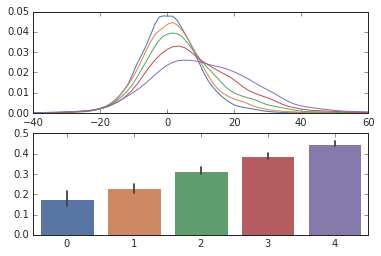

In [29]:
#5
df_sim5 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = .087
                        LIMIT 5000
                    ''')

#10
df_sim10 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = .087 + .087
                        LIMIT 5000
                    ''')

#15
df_sim15 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = .175 + .087
                        LIMIT 5000
                    ''')  

#20
df_sim20 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = .262 + .087
                        LIMIT 5000
                    ''')   

#25
df_sim25 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = .349 + .087
                        LIMIT 5000
                    ''') 


#5
df_simneg5 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = -.087
                        LIMIT 5000
                    ''')

#10
df_simneg10 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = -.087 + -.087
                        LIMIT 5000
                    ''')

#15
df_simneg15 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = -.175 + -.087
                        LIMIT 5000
                    ''')  

#20
df_simneg20 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = -.262 + -.087
                        LIMIT 5000
                    ''')   

#25
df_simneg25 = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Postbout Para Az"
                           FROM bout_population
                        GIVEN
                           "Para Az" = -.349 + -.087
                        LIMIT 5000
                    ''') 



sim5 = np.concatenate((df_sim5["Postbout Para Az"], -1 * df_simneg5["Postbout Para Az"]), axis=0)
sim10 = np.concatenate((df_sim10["Postbout Para Az"], -1 * df_simneg10["Postbout Para Az"]), axis=0)
sim15 = np.concatenate((df_sim15["Postbout Para Az"], -1 * df_simneg15["Postbout Para Az"]), axis=0)
sim20 = np.concatenate((df_sim20["Postbout Para Az"], -1 * df_simneg20["Postbout Para Az"]), axis=0)
sim25 = np.concatenate((df_sim25["Postbout Para Az"], -1 * df_simneg25["Postbout Para Az"]), axis=0)


fig, ax = pl.subplots(2,1)
sb.kdeplot(np.degrees(sim5), color=cp[0], ax=ax[0])
sb.kdeplot(np.degrees(sim10), color=cp[1], ax=ax[0])
sb.kdeplot(np.degrees(sim15), color=cp[2], ax=ax[0])
sb.kdeplot(np.degrees(sim20), color=cp[3], ax=ax[0])
sb.kdeplot(np.degrees(sim25), color=cp[4], ax=ax[0])
ax[0].set_xlim([-40, 60])
fig.savefig('bayesmod_aztransform.pdf')

print np.mean(np.degrees(sim5))
print np.mean(np.degrees(sim10))
print np.mean(np.degrees(sim15))
print np.mean(np.degrees(sim20))
print np.mean(np.degrees(sim25)) 


sb.barplot(data=[np.degrees(sim5) / 5, np.degrees(sim10) / 10, 
                 np.degrees(sim15) / 15, np.degrees(sim20) / 20, 
                 np.degrees(sim25) / 25], palette=cp, ax=ax[1])

0.758840839804
1.90116438569
3.75958258414
6.414620792
9.77593322381


(0, 2)

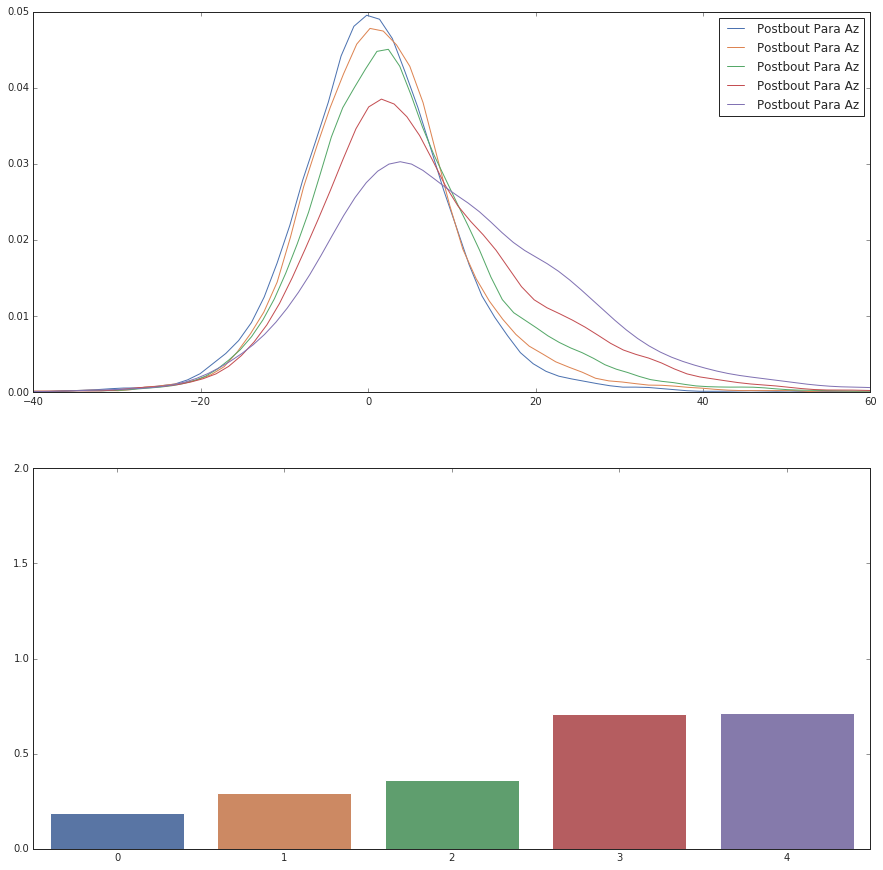

In [16]:
df_sim_az = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Para Az", 
                           "Postbout Para Az"
                           FROM bout_population
                        LIMIT 100000
                    ''') 

df_sim0to5 = df_sim_az[(df_sim_az["Para Az"] < .087) & (df_sim_az["Para Az"] > 0)]
df_sim5to10 = df_sim_az[(df_sim_az["Para Az"] > .087) & (df_sim_az["Para Az"] < .174)]
df_sim10to15 = df_sim_az[(df_sim_az["Para Az"] > .174) & (df_sim_az["Para Az"] < .262)]
df_sim15to20 = df_sim_az[(df_sim_az["Para Az"] > .262) & (df_sim_az["Para Az"] < .349)]
df_sim20to25 = df_sim_az[(df_sim_az["Para Az"] > .349) & (df_sim_az["Para Az"] < .349 + .087)]

fig, ax = pl.subplots(2,1, figsize=(15,15))
sb.kdeplot(np.degrees(df_sim0to5["Postbout Para Az"]), color=cp[0], ax=ax[0])
sb.kdeplot(np.degrees(df_sim5to10["Postbout Para Az"]), color=cp[1], ax=ax[0])
sb.kdeplot(np.degrees(df_sim10to15["Postbout Para Az"]), color=cp[2], ax=ax[0])
sb.kdeplot(np.degrees(df_sim15to20["Postbout Para Az"]), color=cp[3], ax=ax[0])
sb.kdeplot(np.degrees(df_sim20to25["Postbout Para Az"]), color=cp[4], ax=ax[0])
ax[0].set_xlim([-40, 60])
fig.savefig('bayesmod_aztransform.pdf')

# sb.barplot(data=[np.degrees(df_sim0to5["Postbout Para Az"]) / np.degrees(df_sim0to5["Para Az"]), 
#                  np.degrees(df_sim5to10["Postbout Para Az"]) / np.degrees(df_sim5to10["Para Az"]),
#                  np.degrees(df_sim10to15["Postbout Para Az"]) / np.degrees(df_sim10to15["Para Az"]),
#                  np.degrees(df_sim15to20["Postbout Para Az"]) / np.degrees(df_sim15to20["Para Az"]),
#                  np.degrees(df_sim20to25["Postbout Para Az"]) / np.degrees(df_sim20to25["Para Az"])],
#                  ax=ax[1])


mod_az0to5 = make_LM(df_sim0to5["Postbout Para Az"], df_sim0to5["Para Az"])
mod_az5to10 = make_LM(df_sim5to10["Postbout Para Az"], df_sim5to10["Para Az"])
mod_az10to15 = make_LM(df_sim10to15["Postbout Para Az"], df_sim10to15["Para Az"])
mod_az15to20 = make_LM(df_sim15to20["Postbout Para Az"], df_sim15to20["Para Az"])
mod_az20to25 = make_LM(df_sim20to25["Postbout Para Az"], df_sim20to25["Para Az"])


print np.degrees(np.mean(df_sim0to5["Postbout Para Az"]))
print np.degrees(np.mean(df_sim5to10["Postbout Para Az"]))
print np.degrees(np.mean(df_sim10to15["Postbout Para Az"]))
print np.degrees(np.mean(df_sim15to20["Postbout Para Az"]))
print np.degrees(np.mean(df_sim20to25["Postbout Para Az"]))



sb.barplot(data=[[mod_az0to5.params[1]], [mod_az5to10.params[1]], [mod_az10to15.params[1]], 
                 [mod_az15to20.params[1]], [mod_az20to25.params[1]]], palette=cp)



ax[1].set_ylim([0, 2])


In [31]:
std_per_window = [np.std(np.degrees(sim5)), 
                  np.std(np.degrees(sim10)), 
                  np.std(np.degrees(sim15)), 
                  np.std(np.degrees(sim20)), 
                  np.std(np.degrees(sim25))]

angles = [5, 10, 15, 20, 25]

std_fit = make_LM(std_per_window, angles)

print std_fit.summary()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                 0.0492193070838
Method:                          IRLS   Log-Likelihood:                 1.7110
Date:                Wed, 03 Jul 2019   Deviance:                      0.14766
Time:                        03:19:24   Pearson chi2:                    0.148
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.6191      0.233     32.744      0.000         7.163     8.075
x1             0.3566      0.014     25.413      0.0

0.368888888889
Counter({1.0: 68, 0.0: 39, 2.0: 37, 3.0: 12, 5.0: 7, 6.0: 6, 4.0: 5, 8.0: 4, 7.0: 1, 9.0: 1, 11.0: 1})


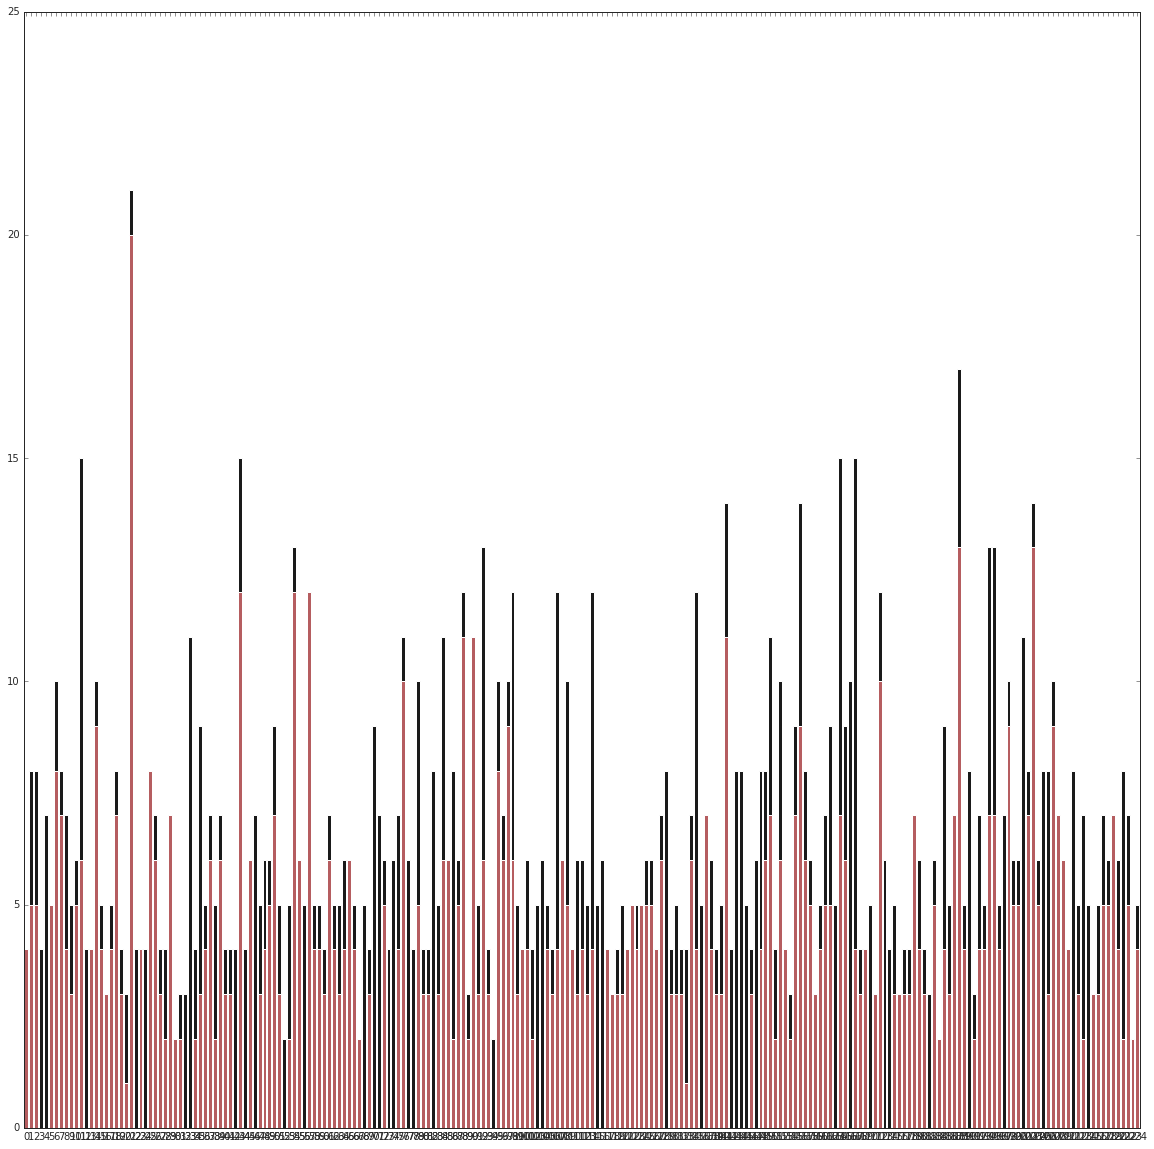

In [56]:

bouts_realfish = np.load('real_fish_bout_distribution.npy')
bouts_rfm = np.load('real_model_results.npy')
bdiff = bouts_realfish - bouts_rfm
bdiff_sum = [i for i in bdiff if (i == 0 or not np.isfinite(i))]
print len(bdiff_sum) / float(len(bdiff))
print Counter(bdiff[np.isfinite(bdiff)])


f, ax1 = pl.subplots(1, figsize=(20,20))
sb.barplot(data=[[b] for b in bouts_realfish], color='k')
sb.barplot(data=[[b] for b in bouts_rfm], color='r')



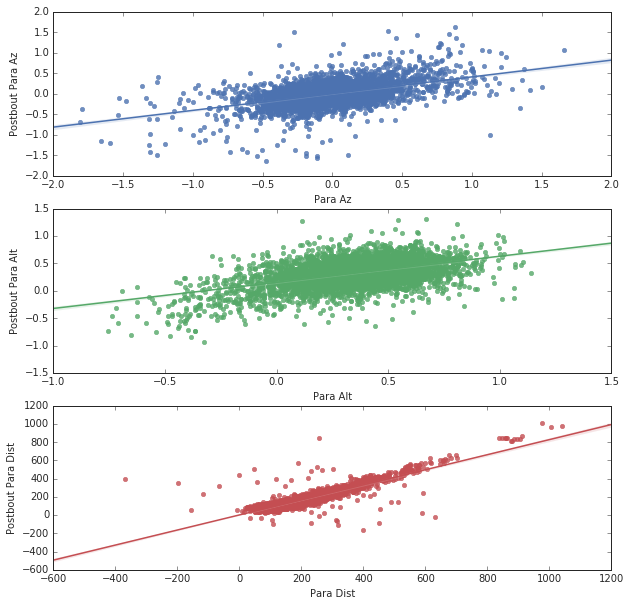

In [11]:
df_sim_az = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Para Az", 
                           "Postbout Para Az"
                           FROM bout_population
                        LIMIT 5000
                    ''') 

df_sim_alt = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Para Alt", 
                           "Postbout Para Alt"
                           FROM bout_population
                        LIMIT 5000
                    ''') 

df_sim_dist = query(marralgs.marr_bdb_file,
                    '''
                        SIMULATE
                           "Para Dist", 
                           "Postbout Para Dist"
                           FROM bout_population
                        LIMIT 5000
                    ''') 

fig, ax = pl.subplots(3, 1, figsize=(10,10))


sb.regplot(df_sim_az["Para Az"], df_sim_az["Postbout Para Az"], ax=ax[0])
sb.regplot(df_sim_alt["Para Alt"], df_sim_alt["Postbout Para Alt"], ax=ax[1])
sb.regplot(df_sim_dist["Para Dist"], df_sim_dist["Postbout Para Dist"], ax=ax[2])



const      0.005817
Para Az    0.407984
dtype: float64
const       0.218294
Para Alt    0.332358
dtype: float64
const       0.170640
Para Alt    1.004767
dtype: float64
const        1.912993
Para Dist    0.826059
dtype: float64
{'alt_m_pos': 0.34278295146135662, 'az_m': 0.40637994407494737, 'dist_m': 0.92912410529735423, 'dist_b': -20.453066259873985, 'alt_b_neg': 0.09661075634664304, 'az_b': 0.012431668950486198, 'alt_b_pos': 0.22227872752614944, 'alt_m_neg': 0.70372697601681078}
One Sample T on Medians
Ttest_1sampResult(statistic=9.6771410459664988, pvalue=2.1357604600843819e-18)
[0.061724777075188253, 0.25053515152930461, 0.15499582955069974]


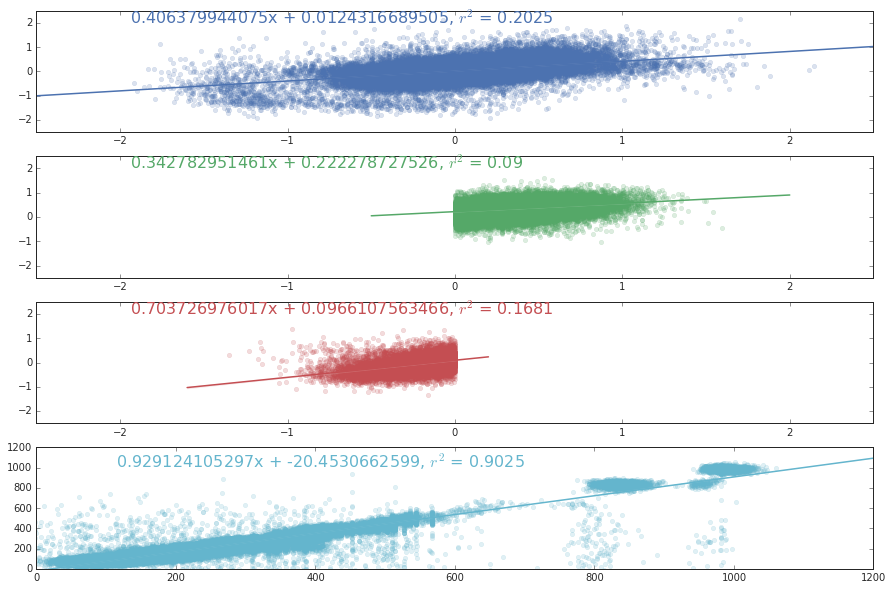

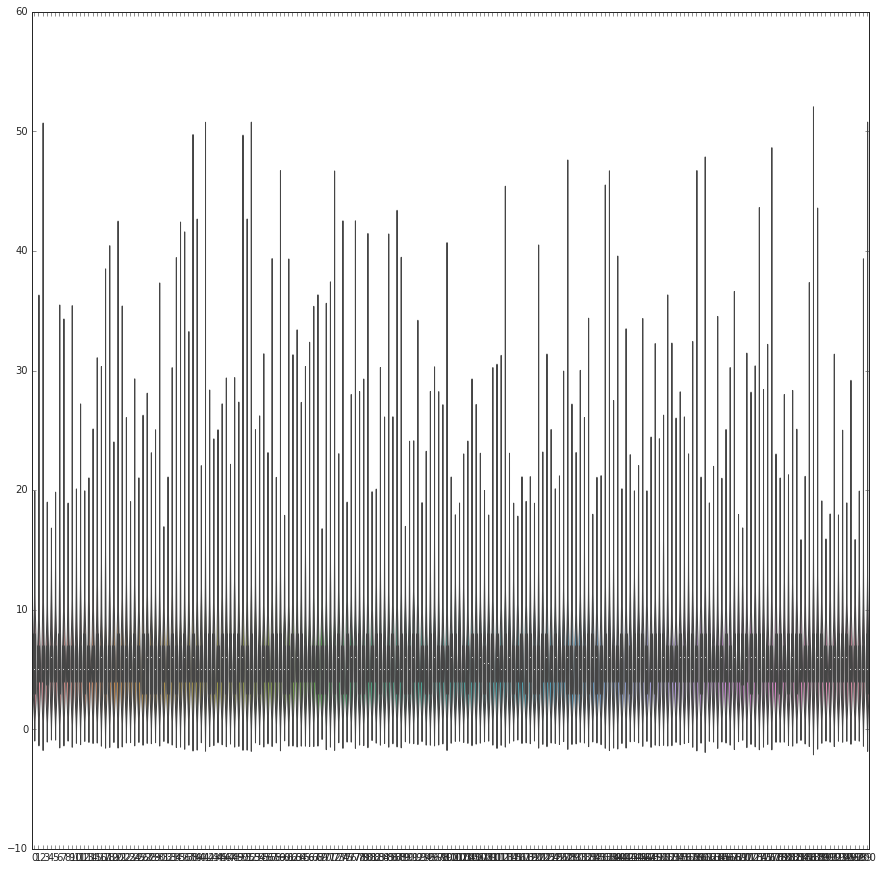

In [12]:
mod_az = make_LM(df_sim_az["Postbout Para Az"], df_sim_az["Para Az"])
print mod_az.params

alt_pos = np.where(df_sim_alt["Para Alt"] > 0)[0]
alt_neg = np.where(df_sim_alt["Para Alt"] < 0)[0]

mod_altpos = make_LM(df_sim_alt["Postbout Para Alt"][alt_pos], df_sim_alt["Para Alt"][alt_pos])
print mod_altpos.params

mod_altneg = make_LM(df_sim_alt["Postbout Para Alt"][alt_neg], df_sim_alt["Para Alt"][alt_neg])
print mod_altneg.params

mod_dist = make_LM(df_sim_dist["Postbout Para Dist"], df_sim_dist["Para Dist"])
print mod_dist.params
marralgs.validate_bayes_model([mod_az, mod_altpos, mod_altneg, mod_dist], 1)

In [ ]:
num_nans_in_bayes = [np.isfinite(b).all() for b in bayes_bouts_for_barplot]
num_nans_in_static = [np.isfinite(b).all() for b in static_bouts]
print Counter(num_nans_in_static)
print Counter(num_nans_in_bayes)

In [ ]:
# test_results contains all wilcoxon comparisons between the static and bayesian models in its first ind
# its second ind contains the sum_of_ranks for each model. 
# averages contains the quartiles for bout count for each model. 

# THIS TTEST WILL GIVE YOU THE PROBABILITY OF SEEING THE BAYES RESULTS GIVEN THE STATIC RESULT
# one_samp_t = ttest_1samp([av[1] for av in marralgs.averages[1:]],
#                                 marralgs.averages[0][1])
# WILL ALSO PRINT OUT THE RESULTS OF THE MANN WHITNEY U TEST (NONPARAMETRIC ONE SAMPLE TEST)


# wilcoxon test results yields how likely one bayesian set of bouts is to be
# greater than the static model. it's a paired test b/c its the same
# initial condition
# sum_of_ranks is how many more times the bayesian model wins
# vs the static model. if the result is negative, the
# static model wins more often.

ranksum_per_model = marralgs.test_results[1]
wilcoxon_pvals_vs_static = [w[1] for w in marralgs.test_results[0]]



fig, ax = pl.subplots(1,2, figsize=(10,10))
sb.violinplot(data=ranksum_per_model, ax=ax[0], bw=.4)
sb.distplot(wilcoxon_pvals_vs_static,bins=40, ax=ax[1])


len(p_inits)

#print ranksum_per_model
#pl.figure()
#sb.violinplot(data=ranksum_per_model)
#pl.figure()
#sb.boxplot(data=wilcoxon_vs_static)



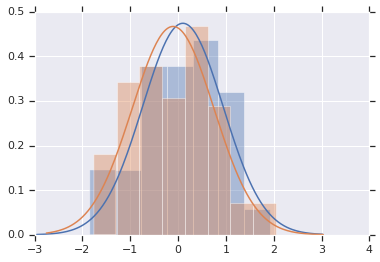

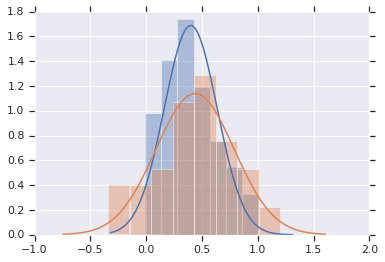

In [27]:
marralgs_static_array = np.array(static_bouts)
long_hunts = np.where(marralgs_static_array > 4)
short_hunts = np.where(marralgs_static_array <= 4)

wins_for_bayes_long = marralgs_static_array[
    long_hunts] - np.nanmedian(bayes_bouts_for_barplot, axis=1)[long_hunts]
wins_for_bayes_short = marralgs_static_array[
    short_hunts] - np.nanmedian(bayes_bouts_for_barplot, axis=1)[short_hunts]

# THIS IS PRECISELY WHAT THE FISH DOES! LOTS OF NOISE ON BIG BOUTS, LESS ON SMALL!

p_init_array = np.array(p_inits)
az_shorthunts = [p["Para Az"] for p in p_init_array[short_hunts]]
alt_shorthunts = [p["Para Alt"] for p in p_init_array[short_hunts]]
az_longhunts = [p["Para Az"] for p in p_init_array[long_hunts]]
alt_longhunts = [p["Para Alt"] for p in p_init_array[long_hunts]]


pl.figure()
sb.distplot(az_shorthunts, fit=norm, fit_kws={"color": cp[0]}, kde=False)
sb.distplot(az_longhunts, fit=norm, fit_kws={"color": cp[1]}, kde=False)

pl.figure()
sb.distplot(alt_shorthunts, fit=norm, fit_kws={"color": cp[0]}, kde=False)
sb.distplot(alt_longhunts, fit=norm, fit_kws={"color": cp[1]}, kde=False)

ValueError: zero-size array to reduction operation minimum which has no identity

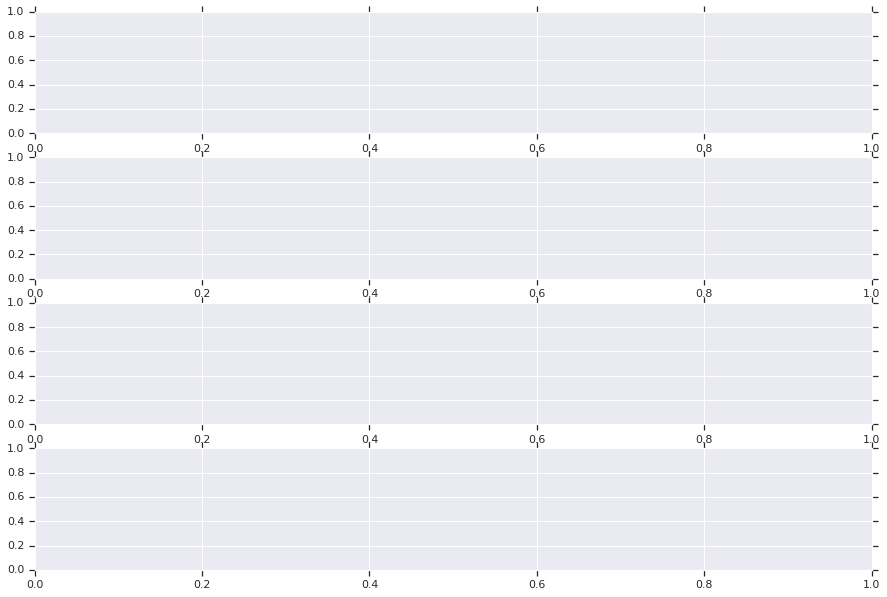

In [42]:
from pc_model import validate_model_transformations
validate_model_transformations(marralgs.prebout_para,
                               marralgs.postbout_para)